# 01_Split_Videos.ipynb

Original code from Carolyn Parkinson & modified for personal use

Creates fslroi command to split whole run into individual videos

Input: 

* Run Ref File
    
    *  /Users/mdclark/Desktop/EmpAcc/data/behavioraldata/scanfiles/239_run_ref.csv
    * Contains "sub_id, trial, video_number, self_other, neg_pos, scan_start, video_start, video_start_rts, run"
   
* Run File
    
Output: 
   
* Video run file

In [1]:
import os
import subprocess
import pandas as pd

from nilearn import input_data
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define a function to execute shell commands
def sh(c):
    '''
    run shell commands
    '''
    subprocess.call(c, shell = True)
    
import math

def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

In [15]:
# get subject data

sub = "245"
subject = "sub-" + sub
run = 2

# set filepaths
data_filepath = os.path.join("/Users/mdclark/Desktop/ISCAnalysis/data/", subject, "func")
                             
reference_filepath = ("/Users/mdclark/Desktop/EmpAcc/data/behavioraldata/")
run_ref_filepath = os.path.join(reference_filepath, "scanfiles", sub + "_run_ref.csv")
run_duration_filepath = os.path.join(reference_filepath, "scanfiles_derivatives/rundata/video_timing", subject + "_task-emp_run-0" + str(run) + "_events_other.txt")

# load reference file information
run_ref = pd.DataFrame.from_csv(run_ref_filepath)
run_duration = pd.DataFrame.from_csv(run_duration_filepath, sep="\t").reset_index()
run_ref = pd.merge(run_ref, run_duration, on='video_number')



In [16]:
# Get data only for relevant epi run

run_ref = run_ref[run_ref.run == run]

run_ref['video_number'] = run_ref['video_number'].astype(int)

#Calculate trs
# add three to account for hemodynamic lag
run_ref['video_start_tr'] = \
    [round_up_to_even(x)/2 + 3 for x in run_ref['video_start_rts']]

run_ref['video_duration_tr'] = run_ref['duration']/2

In [17]:
# Split each epi into four videos
for index, video in enumerate(run_ref['video_number'].tolist()): 

    run_filename = "sub-" + sub + "_task-emp_run-0" + str(run) + "_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"
    bold_input_filename = os.path.join(data_filepath, run_filename)

    video_filename = ("video_{video}.nii.gz").format(video=str(video))
    bold_output_filename = os.path.join(data_filepath, video_filename)

    start = run_ref.iloc[index]['video_start_tr']
    duration = run_ref.iloc[index]['video_duration_tr']

    sh_cmd = ("""fslroi \
          {bold_input_filename}\
          {bold_output_filename}\
          {start}\
          {duration}""").format(bold_input_filename=bold_input_filename, bold_output_filename=bold_output_filename, start=start, duration=duration)
    sh(sh_cmd)
    print(sh_cmd)

fslroi           /Users/mdclark/Desktop/ISCAnalysis/data/sub-245/func/sub-245_task-emp_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz          /Users/mdclark/Desktop/ISCAnalysis/data/sub-245/func/video_4.nii.gz          9.0          59.964532763500756
fslroi           /Users/mdclark/Desktop/ISCAnalysis/data/sub-245/func/sub-245_task-emp_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz          /Users/mdclark/Desktop/ISCAnalysis/data/sub-245/func/video_9.nii.gz          77.0          43.97303196449865
fslroi           /Users/mdclark/Desktop/ISCAnalysis/data/sub-245/func/sub-245_task-emp_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz          /Users/mdclark/Desktop/ISCAnalysis/data/sub-245/func/video_6.nii.gz          129.0          59.7929013565008
fslroi           /Users/mdclark/Desktop/ISCAnalysis/data/sub-245/func/sub-245_task-emp_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz          /Users/mdclark/Desktop/ISCAnalysis/data/sub-245/func/video_14.nii.gz         

(68, 80, 68, 256)
(68, 80, 68, 59)
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x14d013898>, <nilearn.input_data.nifti_spheres_masker._ExtractionFunctor object at 0x14d013e80>, 
{ 'allow_overlap': False,
  'detrend': True,
  'high_pass': 0.01,
  'low_pass': 0.1,
  'mask_img': None,
  'radius': 8,
  'seeds': [(-56, -4, -10), (56, -4, -10), (28, -96, -6), (-28, -96, -6)],
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': 2}, confounds=None, memory=Memory(cachedir='nilearn_cache/joblib'), memory_level=1, verbose=1)
[NiftiSpheresMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(68, 80, 68, 256),
affine=array([[   2.9000001,    0.       ,    0.       ,  -96.       ],
       [   0.       ,    2.9000001,    0.       , -132.       ],
       [   0.       ,    
[NiftiSpheresMasker.transform_single_imgs] Extra

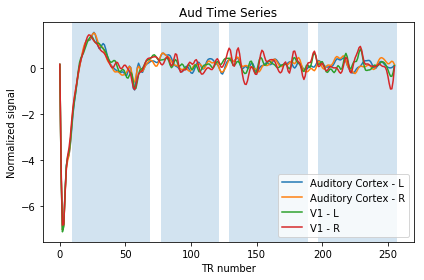

In [18]:
#Coded to check that TR onset and offset timing are correct

from nilearn import image
from nilearn import plotting


#Load original and cut data
bold_input = image.smooth_img(bold_input_filename, fwhm=3)
bold_output= image.smooth_img(bold_output_filename, fwhm=3)

print(bold_input.shape)
print(bold_output.shape)

#Guess auditiory cortex seed
aud_coords = [(-56,-4,-10),(56,-4,-10),(28,-96,-6),(-28,-96,-6)]
labels = ['Auditory Cortex - L', 'Auditory Cortex - R', 'V1 - L', 'V1 - R']

#Make mask of auditory cortex
masker = input_data.NiftiSpheresMasker(
    aud_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=1)


time_series = masker.fit_transform(bold_input)

for time_serie, label in zip(time_series.T, labels):
    plt.plot(time_serie, label=label)


plt.axvspan(run_ref.iloc[0]['video_start_tr'],run_ref.iloc[0]['video_start_tr'] + run_ref.iloc[0]['video_duration_tr'], alpha =.2)
plt.axvspan(run_ref.iloc[1]['video_start_tr'],run_ref.iloc[1]['video_start_tr'] + run_ref.iloc[1]['video_duration_tr'], alpha =.2)
plt.axvspan(run_ref.iloc[2]['video_start_tr'],run_ref.iloc[2]['video_start_tr'] + run_ref.iloc[2]['video_duration_tr'], alpha =.2)
plt.axvspan(run_ref.iloc[3]['video_start_tr'],run_ref.iloc[3]['video_start_tr'] + run_ref.iloc[3]['video_duration_tr'], alpha =.2)


plt.title('Aud Time Series')
plt.xlabel('TR number')
plt.ylabel('Normalized signal')
plt.legend()
plt.tight_layout()


plt.savefig(data_filepath + "/run-" +  str(run) + ".png")